# Motivation
In the previous notebook (**`01. Detecting a Boggle Board`**), I familiarized myself with a couple of the tactics I could use to process pictures of Boggle boards. In this notebook, I want to refine that technique, and try to make it a little more foolproof. 

Here's a general overview of my strategy: 

1. Apply Contour Detection to identify the Boggle Board ([tutorial here](https://learnopencv.com/contour-detection-using-opencv-python-c/))
2. Warp the perspective of the board to achieve a more top-down view
3. Apply contour detection *again*, and then try and use the contour hierarchies to identify the letters within the Boggle board 
4. Try and refine the extraction of the letters, cleaning them up 
5. Apply OCR on each of the letters



# Setup
The cells below will set up the rest of this notebook. 

First, I'll configure the kernel: 

In [1]:
# Change directories to the root of the project
%cd ..

# Enable autoreload of modules
%load_ext autoreload
%autoreload 2

d:\data\programming\boggle-vision


Next, I'll import some relevant libraries:

In [2]:
# Import statements
import cv2
import pandas as pd
from pathlib import Path
import math
from matplotlib import pyplot as plt
import numpy as np
from statistics import mode
import old_utils
import cv2
import pytesseract
from PIL import Image
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Methods
As I define methods to be used throughout the notebook, I'll move them up here. 

This first one will resize an image to a particular scale. 

In [3]:
def resize_image(desired_height, image):
    """
    This function resizes an image to a desired height while maintaining the aspect ratio.
    """

    # Resize image
    height, width = image.shape[:2]
    aspect_ratio = width / height
    desired_width = int(desired_height * aspect_ratio)
    return cv2.resize(
        image, (desired_width, desired_height), interpolation=cv2.INTER_AREA
    )

# Loading Data
First, I'm going to load in all of the different pictures. I'll put them into a DataFrame; that way, I can more easily test the process across all of them at once. 

In [4]:
max_height_for_pic = 2000

# Iterate through the test-pictures folder
pictures_df_records = []
for child_file in Path("data/test-pictures/").iterdir():
    # If the child_file is a .png file, then we want to process it
    if child_file.suffix == ".png":
        # Only add the file if it's prefixed with "easy", "medium", or "hard"
        if (
            child_file.name.startswith("easy")
            or child_file.name.startswith("medium")
            or child_file.name.startswith("hard")
        ):
            pictures_df_records.append(
                {
                    "file_name": child_file.stem,
                    "file_path": str(child_file),
                    "image": resize_image(max_height_for_pic, cv2.imread(str(child_file))),
                    "number": int(child_file.stem.split("-")[-1]),
                    "difficulty": child_file.stem.split("-")[0],
                }
            )

# Create a DataFrame from the records
pictures_df = pd.DataFrame(pictures_df_records)

# Board Detection Process
Below, I'm going to run through the board detecgtion process. 

### **Step 0:** Parameterizing the Detection Process
There are a couple of general settings I want to declare for the board detection process - I'll declare those here. 

In [19]:
# Indicating a test image to use (one that's easy)
input_image = pictures_df.query("difficulty == 'easy'").iloc[1].image

# Indicating the pixel brightness threshold for the binary thresholding
binary_threshold = 100

# Determine how many contours to check in the initial contour detection
initial_contour_detection_n_to_process = 15

# Indicate the maximum amount of children contours for a contour to be considered a board
max_children_contours = 80

# Indicate the maximum amount of the picture that a board can take up
board_max_area = 0.7
board_min_area = 0.15

# Indicate the amount that we'll be deflating the board contour by
board_contour_expansion_amount = 15

### **Step 1:** Contour Detection for Locating the Board
The first step we'll do: try and run through some contour detection for finding the board. 

Essentially, we're going to look for a "mostly-squareish", large contour. This is hopefully the board. I'll start by running contour detection.

In [20]:
# Determine the area of the input image (this is for later)
entire_image_area = input_image.shape[0] * input_image.shape[1]

# Start by converting the image to greyscale
gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

# Apply some binary thresholding to the greyscale image
ret, thresholded_image = cv2.threshold(
    gray_image, binary_threshold, 255, cv2.THRESH_BINARY
)

# Detect the contours on the thresholded image
contours, hierarchy = cv2.findContours(
    thresholded_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
)

Now I'm going to want to iterate through the hiearchy to determine which contours are actually the board. 

**NOTE:** This is a fairly difficult problem.

In [21]:
# Find the contours that have the most immediate children
repeated_parents_list = [
    contour_navlist[-1] for contour_navlist in hierarchy[0] if contour_navlist[-1] != -1
]
most_common_parents = list(
    pd.DataFrame(repeated_parents_list)
    .value_counts()
    .head(initial_contour_detection_n_to_process)
    .reset_index()[0]
)

# Retreive the contours that have the most immediate children
most_common_parent_contours = [contours[i] for i in most_common_parents]

# Iterate through each of the contours to find square-ish shapes
# https://chat.openai.com/share/5b096067-aa3c-4632-804e-2b9cfa719933
# TODO: This is definitely a bit hacky; I should come back to this
board_contour = None
square_ish_contours = []
for i, cur_contour in enumerate(most_common_parent_contours):
    # Approximate teh contour to a polygon
    epsilon = 0.05 * cv2.arcLength(cur_contour, True)
    polygon = cv2.approxPolyDP(cur_contour, epsilon, True)

    # If the polygon has 4 points, then we can assume we have found the board
    if len(polygon) == 4:
        square_ish_contours.append(polygon)

# Now, iterate through the square-ish contours and find the one that is the largest
largest_contour_area = 0
for cur_contour in square_ish_contours:
    
    # If the current contour's area is larger than the largest contour's area, then
    # we'll set the largest contour to the current contour
    cur_contour_area = cv2.contourArea(cur_contour)
    if cur_contour_area > largest_contour_area and cur_contour_area <= (entire_image_area * board_max_area) and cur_contour_area >= (entire_image_area * board_min_area):
        largest_contour_area = cur_contour_area
        board_contour = cur_contour

# If the board contour is still None, then we didn't find a board
if board_contour is None:
    print("No board was found.")

Next: I'm going to slightly "expand" the contour that I've found. 

In [22]:
# TODO: Learn about this method more, since I'd copied it from ChatGPT ðŸ˜‚


def expand_contour(contour, dilation_size=5):
    # Create an empty mask to draw the contour onto
    mask = np.zeros(input_image.shape[:2], dtype=np.uint8)

    # Draw the contour onto the mask (using a thickness of -1 to fill the contour)
    cv2.drawContours(mask, [contour], -1, (255), thickness=-1)

    # Create a structuring element for the dilation
    kernel = np.ones((dilation_size, dilation_size), np.uint8)

    # Dilate the mask
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)

    # Find the contours of the dilated mask
    dilated_contours, _ = cv2.findContours(
        dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # The dilated contour will be the one with the largest area
    dilated_contour = max(dilated_contours, key=cv2.contourArea)

    # Simplify the dilated contour
    dilated_contour = cv2.approxPolyDP(
        dilated_contour, 0.02 * cv2.arcLength(dilated_contour, True), True,
    )

    return dilated_contour

Now - if `board_contour` is not `None` at this stage, then we've supposedly found our board. I'll display it below: 

C:\Users\trevb_b7z2dw1\AppData\Local\Temp\ipykernel_32864\2597348357.py:28: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box_points = np.int0(box_points)


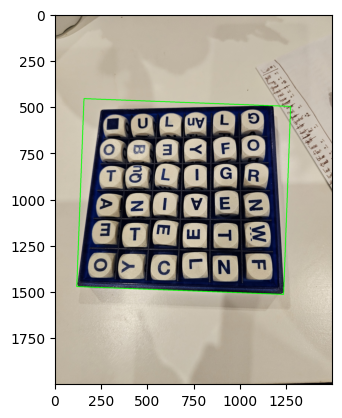

In [33]:
if board_contour is None:
    final_board_contour = None
    print(f"FAILED TO FIND THE BOARD!")
    image_copy = input_image.copy()
    plt.imshow(
        cv2.drawContours(
            image_copy,
            # contours=[polygon],
            contours=contours,
            contourIdx=-1,
            color=(0, 255, 0),
            thickness=4,
        )
    )
    plt.imshow(image_copy, cmap="gray")
    plt.show()
else:
    # Add the expansion of the board contour
    expanded_contour = expand_contour(board_contour, 12)

    # Find the minimum area rectangle
    min_rect = cv2.minAreaRect(expanded_contour)

    # Calculate the box points
    box_points = cv2.boxPoints(min_rect)

    # Convert box_points to an integer array (necessary for drawing the contour)
    box_points = np.int0(box_points)

    # Create a new contour from the box points
    bounding_rect_contour = box_points.reshape((-1, 1, 2))
    final_board_contour = bounding_rect_contour

    # Draw this final contour
    image_copy = input_image.copy()
    image_copy = cv2.drawContours(
        image_copy,
        # contours=[polygon],
        contours=[final_board_contour],
        contourIdx=-1,
        color=(0, 255, 0),
        thickness=4,
    )
    plt.imshow(cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB), cmap="gray")
    plt.show()

### **Step 2:** Warping Perspective to Top-Down
At this point, I've hopefully found the board. Now, I need to warp the perspective of the image to be centered around the board.

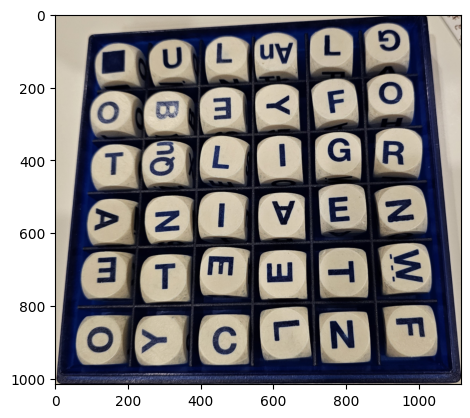

In [34]:
def warp_perspective_to_top_down(img, contour):
    """
    This method will take an image and a contour and warp the image to a top-down view. 
    The method will return the warped image.
    """
    
    # Determine the corner points of the board
    corner_points = [contour_corner[0].tolist() for contour_corner in contour]

    # Unpack the corner points
    pt_A, pt_B, pt_C, pt_D = corner_points

    # Use the L2 norm to calculate the width and height of the new image
    width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
    width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
    maxWidth = max(int(width_AD), int(width_BC))
    height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
    height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
    maxHeight = max(int(height_AB), int(height_CD))

    # Compute the perspective transform matrix
    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
    output_pts = np.float32(
        [[0, 0], [0, maxHeight - 1], [maxWidth - 1, maxHeight - 1], [maxWidth - 1, 0]]
    )
    M = cv2.getPerspectiveTransform(input_pts, output_pts)

    warped_image = cv2.warpPerspective(
        img, M, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR
    )
    
    # Flip the image horizontally and return it 
    return cv2.flip(warped_image, 0)

# We're only going to run the perspective transform if there are 4 corners
if final_board_contour is not None and len(final_board_contour) == 4: 
    
    # Warp the image to a top-down view
    board_image = warp_perspective_to_top_down(input_image, final_board_contour)
    
    # Display the image using matplotlib
    plt.imshow(cv2.cvtColor(board_image, cv2.COLOR_BGR2RGB))
    plt.show()

# If there aren't 4 corners, we'll just use the original image
else:
    print(f"THE CONTOUR DOESN'T HAVE 4 CORNERS!")

### **Step 3:** Tile/Letter Contour Detection
Now, I need to run contour detection again - this time on the newly extracted `board_image`. 

My idea here: I want to try and detect contours that have roughly the same size. 

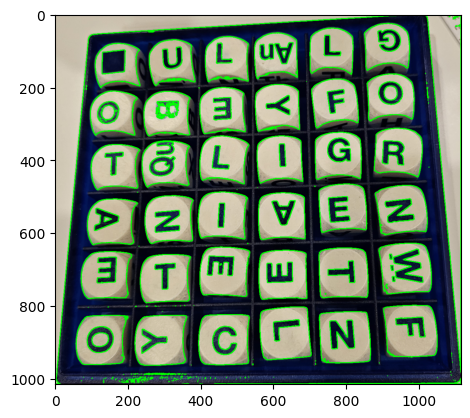

In [35]:
# Start by converting the image to greyscale
gray_board_image = cv2.cvtColor(board_image, cv2.COLOR_BGR2GRAY)

# # Apply Gaussian blur to the greyscale image
# blurred_board_image = cv2.GaussianBlur(gray_board_image, (15, 15), 0)

# # Apply some binary thresholding to the greyscale image
# thresholded_board_image = cv2.adaptiveThreshold(
#     blurred_board_image, 200, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 5
# )

ret, thresholded_board_image = cv2.threshold(
    gray_board_image, binary_threshold, 255, cv2.THRESH_BINARY)

# Detect the contours on the thresholded image
contours, hierarchy = cv2.findContours(
    thresholded_board_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
)

board_image_copy = board_image.copy()
board_image_copy = cv2.drawContours(
    board_image_copy,
    # contours=[polygon],
    contours=contours,
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=2,
)
plt.imshow(cv2.cvtColor(board_image_copy, cv2.COLOR_BGR2RGB), cmap="gray")
plt.show()

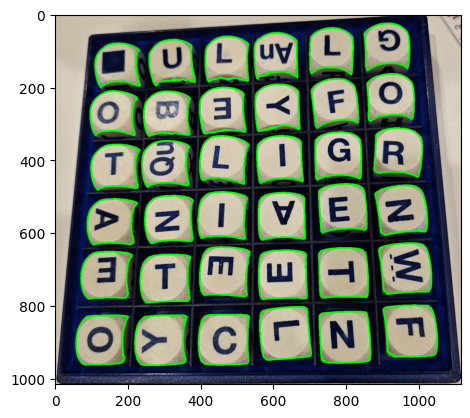

In [36]:
# Calculate the total area of the image
board_image_area = board_image.shape[0] * board_image.shape[1]

contour_df = pd.DataFrame(
    [
        {
            "idx": idx,
            "area": cv2.contourArea(contour),
        }
        for idx, contour in enumerate(contours)
    ]
)

# Filter out some noise from the contour DataFrame
noise_filtered_contour_df = contour_df.query("area > 0").sort_values(
    "area", ascending=False
)

# Add a column indicating the difference in size between each contour
difference = []
difference_pct = []
prev_row_area = noise_filtered_contour_df.iloc[0].area * 2
for idx, row in noise_filtered_contour_df.iterrows():
    difference.append(prev_row_area - row.area)
    difference_pct.append((prev_row_area - row.area) / prev_row_area)
    prev_row_area = row.area
noise_filtered_contour_df["difference"] = difference
noise_filtered_contour_df["difference_pct"] = difference_pct
noise_filtered_contour_df = noise_filtered_contour_df.reset_index(drop=True)

noise_filtered_contour_df["pct_of_image"] = noise_filtered_contour_df.area / board_image_area

noise_filtered_contour_df = noise_filtered_contour_df.query("pct_of_image < 0.02")

# Iterate through each contour and try and locate the tiles
size_difference_threshold = 0.4
tile_contour_idxs = []
prev_row = noise_filtered_contour_df.iloc[0]
for idx, row in enumerate(list(noise_filtered_contour_df.itertuples())):
    if idx == 0:
        continue
    if row.difference_pct <= size_difference_threshold:
        tile_contour_idxs.append(prev_row.idx)
        tile_contour_idxs.append(row.idx)
    elif row.difference_pct > size_difference_threshold and len(tile_contour_idxs) > 0:
        break
    prev_row = row
tile_contour_idxs = list(set(tile_contour_idxs))

# Now, get the bounding boxes for each tile
tile_contours = [contours[int(idx)] for idx in tile_contour_idxs]

board_image_copy = board_image.copy()
board_image_copy = cv2.drawContours(
    board_image_copy,
    # contours=[polygon],
    contours=tile_contours,
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=3,
)
plt.imshow(cv2.cvtColor(board_image_copy, cv2.COLOR_BGR2RGB), cmap="gray")
plt.show()

### **Step 4:** Cleaning Tile Images
Next, I need to clean up the images of the tiles that we've extracted. 

I've got contours for each the tiles. I want to approximate polygons for each of them, and then create new images from each of them. 

In [27]:
# We're going to store the square-ified contours in this list
square_tile_contours = []
# Iterate through each of the tile contours
for tile_contour in tile_contours:
    # Find the minimum area rectangle
    min_rect = cv2.minAreaRect(tile_contour)

    # Calculate the box points
    box_points = cv2.boxPoints(min_rect)

    # Convert box_points to an integer array (necessary for drawing the contour)
    box_points = np.int0(box_points)

    # Create a new contour from the box points
    square_tile_contours.append(box_points.reshape((-1, 1, 2)))

C:\Users\trevb_b7z2dw1\AppData\Local\Temp\ipykernel_32864\2397848747.py:12: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box_points = np.int0(box_points)


With the square contours created, we're going to warp the perspectives so that we're showing all of the letters.

In [28]:
board_tile_df_records = []
tile_idx_to_image = {}
for idx, square_tile_contour in enumerate(square_tile_contours):
    cur_tile_centroid = np.mean(square_tile_contour, axis=0)[0]
    board_tile_df_records.append(
        {
            "contour": square_tile_contour,
            "tile_idx": idx,
            "centroid_x": cur_tile_centroid[0],
            "centroid_y": cur_tile_centroid[1],
        }
    )
    tile_idx_to_image[idx] = warp_perspective_to_top_down(
        board_image, square_tile_contour
    )
board_tile_df = pd.DataFrame(board_tile_df_records).sort_values(
    ["centroid_y", "centroid_x"], ascending=[True, True]
)

Finally, we're going to edit the board tile images to only show the child contours. 

In [29]:
# We're going to collect each of the images in this dictionary
tile_idx_to_letter_image = {}

# Iterate over each tile image
for idx, cur_tile_row in enumerate(list(board_tile_df.itertuples())):
    cur_tile_image = tile_idx_to_image[cur_tile_row.tile_idx]

    # Get the area of the cur_tile_image
    cur_tile_image_area = cur_tile_image.shape[0] * cur_tile_image.shape[1]

    # Apply contour detection on the image
    grey_tile_image = cv2.cvtColor(cur_tile_image, cv2.COLOR_BGR2GRAY)

    # Apply some Gaussian blurring to the greyscale image
    blurred_tile_image = cv2.GaussianBlur(grey_tile_image, (7, 7), 0)

    # # Apply some binary thresholding to the greyscale image
    thresholded_tile_image = cv2.adaptiveThreshold(
        blurred_tile_image,
        200,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        41,
        5,
    )

    contours, hierarchy = cv2.findContours(
        thresholded_tile_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )
    hierarchy_df = old_utils.hierarchy_to_dataframe(hierarchy)

    # Calculate the areas of each contour and add it to the dataframe
    contour_areas = [cv2.contourArea(c) for c in contours]
    hierarchy_df["contour_area"] = contour_areas
    hierarchy_df["pct_of_total_area"] = (
        hierarchy_df["contour_area"] / cur_tile_image_area
    )

    # Figure out the midpoint of each contour
    hierarchy_df["contour_midpoint"] = hierarchy_df.apply(
        lambda x: np.mean(contours[x.contour_idx], axis=0)[0], axis=1
    )
    hierarchy_df["contour_midpoint_x"] = hierarchy_df["contour_midpoint"].apply(
        lambda x: x[0]
    )
    hierarchy_df["contour_midpoint_y"] = hierarchy_df["contour_midpoint"].apply(
        lambda x: x[1]
    )
    hierarchy_df = hierarchy_df.drop(columns=["contour_midpoint"])

    original_hierarchy_df = hierarchy_df.copy()

    underline_contours = old_utils.identify_underline_contours(
        thresholded_tile_image, hierarchy_df
    )

    # Filter out level-1 contours that are too small
    hierarchy_df = pd.concat(
        [
            hierarchy_df.query("hierarchy_level != 1"),
            hierarchy_df.query("hierarchy_level == 1 and pct_of_total_area >= 0.03"),
            original_hierarchy_df[
                original_hierarchy_df["contour_idx"].isin(underline_contours)
            ],
        ]
    ).drop_duplicates(subset=["contour_idx"])

    # We're going to check if the largest level 1 contour is a rectangle.
    largest_level_1_contour_idx = (
        hierarchy_df.query("hierarchy_level==1")
        .sort_values("contour_area", ascending=False)
        .head(1)
        .iloc[0]
        .contour_idx
    )
    largest_level_1_contour = contours[largest_level_1_contour_idx]
    epsilon = 0.025 * cv2.arcLength(largest_level_1_contour, True)
    poly_approx = cv2.approxPolyDP(largest_level_1_contour, epsilon, True)

    # If the approximated polygon is a rectangle, then this tile is either "I" or
    # the blank tile. We'll remove any level 2 contours.
    if len(poly_approx) == 4:
        hierarchy_df = hierarchy_df.query("hierarchy_level != 2")

    # Find the largest contour that's not the outermost contour
    level_1_contours = [
        contours[idx]
        for idx in list(
            hierarchy_df[hierarchy_df["hierarchy_level"] == 1]["contour_idx"]
        )
    ]
    level_2_contours = [
        contours[idx]
        for idx in list(
            hierarchy_df[hierarchy_df["hierarchy_level"] >= 2]["contour_idx"]
        )
    ]

    mask = np.zeros_like(cur_tile_image)
    new_mask = cv2.drawContours(
        mask, level_1_contours, -1, (255, 255, 255), thickness=cv2.FILLED
    )
    inside_fill = cv2.drawContours(
        new_mask, level_2_contours, -1, (0, 0, 0), thickness=cv2.FILLED
    )

    # Invert the mask
    # inverted_mask = cv2.bitwise_not(new_mask)
    inverted_mask = new_mask

    # Store the inverted image in the tile_idx_to_letter_image dict
    tile_idx_to_letter_image[cur_tile_row.tile_idx] = inverted_mask
    
    # if idx == 10:
    #     break


Now we can show what the board looks like: 

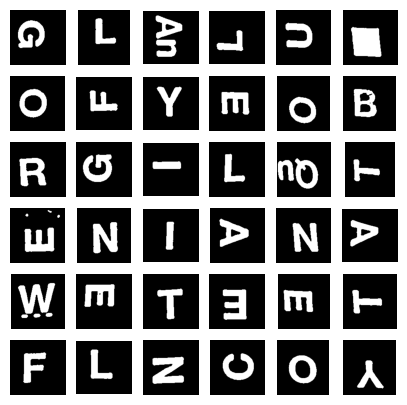

In [30]:
old_utils.display_images_in_grid([tile_idx_to_letter_image[tile_id] for tile_id in board_tile_df["tile_idx"]])

### **Step 5: Applying OCR to Letters**
Now that I've got clean images of the tiles, I need to apply OCR to them. 

In [31]:
# Declare the reader we're going to use
import easyocr

reader = easyocr.Reader(["en"], gpu=False)

# We're going to process all of the tiles in parallel
futures = {}
result_df_dict = {}
with ThreadPoolExecutor() as executor:
    # Iterate through all of the rows in the board_tile_df
    for row in board_tile_df.itertuples():
        cur_tile_idx = row.tile_idx
        cur_tile_img = tile_idx_to_letter_image[cur_tile_idx]
        futures[cur_tile_idx] = executor.submit(
            old_utils.multi_engine_tile_processing, cur_tile_img, reader
        )

    # Now, we'll collect the results of the futures
    for tile_idx, future in tqdm(list(futures.items())):
        result_df_dict[tile_idx] = future.result()

# Now, we're going to collect the different
tile_idx_to_best_prediction = {}
for tile_idx, result_df in result_df_dict.items():
    tile_idx_to_best_prediction[tile_idx] = old_utils.aggregate_prediction_results(
        result_df, min_prediction_confidence=0.6
    )

# Store these results in a DataFrame
board_tiles_with_predictions_df = board_tile_df.copy()

board_tiles_with_predictions_df["text_prediction"] = board_tiles_with_predictions_df[
    "tile_idx"
].apply(lambda cur_tile_idx: tile_idx_to_best_prediction[cur_tile_idx][0])

board_tiles_with_predictions_df[
    "rotation_prediction"
] = board_tiles_with_predictions_df["tile_idx"].apply(
    lambda cur_tile_idx: tile_idx_to_best_prediction[cur_tile_idx][1]
)

Using CPU. Note: This module is much faster with a GPU.
100%|â–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆâ–ˆ| 36/36 [00:35<00:00,  1.02it/s]


Now that we've done that, we're going to show off the different tiles, as well as the predictions:

['G', 'L', 'An', 'L', 'U', 'R']
['O', 'F', 'Y', 'E', 'O', 'B']
['R', 'G', 'H', 'L', 'Qu', 'T']
['E', 'N', 'H', 'A', 'N', 'A']
['W', 'E', 'T', 'E', 'E', 'T']
['F', 'L', 'N', 'C', 'O', 'Y']


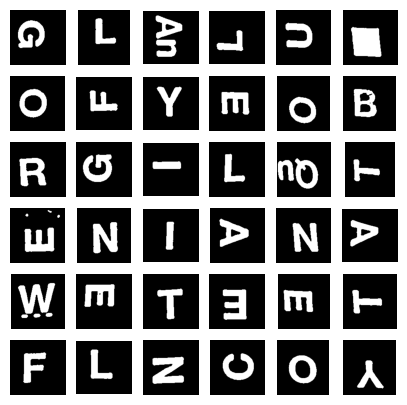

In [32]:
row_size = 6
lines = []
cur_line = []
for row in board_tiles_with_predictions_df.itertuples():
    cur_line.append(row.text_prediction)
    if len(cur_line) == row_size:
        lines.append(cur_line)
        cur_line = []
for line in lines:
    print(line)
old_utils.display_images_in_grid(
    [tile_idx_to_letter_image[tile_id] for tile_id in board_tile_df["tile_idx"]]
)

**NOTES:**
- "I" tiles don't always seem to be detected. One of them was, but another one wasn't. 
- The "block" tile also isn't detected
- There's SOME trouble detecting the letter "D" - it sometimes reads them as "O". We might want to increase the weight associated with skeletons in those instances - not entirely sure. 
- It seems to do a decent job at detecting W's over M's, but definitely thinks that "Z"s are "N"
- The function is generally a little slow. I'm not entirely sure *why* that is - probably something with the `easyocr` model being loaded multiple times / not being on CPU.
- C can sometimes be mistaken for O.
- Y can be mistaken for A. 

### **Step 6:** Constructing the Board Data Structure
Now that I've run OCR on all of the letters, I can output the board's data structure.